In [14]:
import time
from tqdm import tqdm
import math
from scipy import special, stats, optimize, fft
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_theme()

import pydub
import numpy as np

In [27]:
# import ffprobe
import sys
sys.path.append('/usr/local/bin/ffmpeg')

In [28]:
# helper funkcija za loadanje mp3 ... nekje iz stackoverflowa
# https://stackoverflow.com/questions/53633177/how-to-read-a-mp3-audio-file-into-a-numpy-array-save-a-numpy-array-to-mp3
def read_sound(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

In [17]:
def autocorrelation(x):
    xp = fft.ifftshift((x - np.average(x))/np.std(x))
    n, = xp.shape
    xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
    f = fft.fft(xp)
    p = np.absolute(f)**2
    pi = fft.ifft(p)
    return np.real(pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)


def phi_gh(g,h):
    # xp = fft.ifftshift((x - np.average(x))/np.std(x))
    n, = g.shape
    # xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
    G = fft.fft(g)
    H = fft.fft(h)

    P = G*np.conj(H)
    # p = np.absolute(f)**2
    Pi = fft.ifft(P)
    return np.real(Pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)

In [18]:
# rate je itak 44.1 kHz
rate, bubomono = read_sound('posnetki/bubomono.wav')
_, bubomono2 = read_sound('posnetki/bubo2mono.wav')

_, mix = read_sound('posnetki/mix.wav')
_, mix1 = read_sound('posnetki/mix1.wav')
_, mix2 = read_sound('posnetki/mix2.wav')
_, mix22 = read_sound('posnetki/mix22.wav')

In [19]:
def plot_spectogram(y, rate, name="", max_freqs=1):
    plt.figure(figsize=(15, 4))
    plt.subplot(131)
    x = np.arange(len(y))/rate
    plt.title(f"Signal {name}")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.plot(x,y)    

    plt.subplot(132)
    spectrum,  freqs, t, spec_im, = plt.specgram(y, Fs=rate ,vmin=0,cmap='Purples')
    plt.colorbar(spec_im).set_label('Intensiteta')
    plt.ylim([0,3000])
    plt.title(f"Spektogram signala {name}")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")

    plt.subplot(133)
    plt.title(f"Fourierova transformacija {name}")
    freqs = np.arange(rate/2)
    freqs_y = fft.fft(y, n=rate)
    # ker itak dobimo simetricno
    y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])
    max_freqs = freqs[np.argsort(y)[-max_freqs:]]
    for freq in max_freqs:
        plt.axvline(freq, color='r', label=fr'$\nu_m = {int(freq)} Hz$')
    plt.plot(freqs[:1000], y[:1000], label='$F(inpt)$')
    plt.xlabel("Frequency [Hz]")
    plt.legend()
    plt.savefig(f'plots/{name}_fourier_max.pdf', bbox_inches='tight')
    plt.show()

Najlažje se je naloge sicer lotiti malce bolj primitivno. Kar lahko naredimo je, da za vsak vhodni signal narišemo fourierovo transformacijo in pogledamo, kje je maksimalna frekvenca. To deluje zelo dobro, ker je frekvenca sove konstantna in nakoncu prevlada. Torej lahko z zelo malo dela opazimo, katera sova je katera.

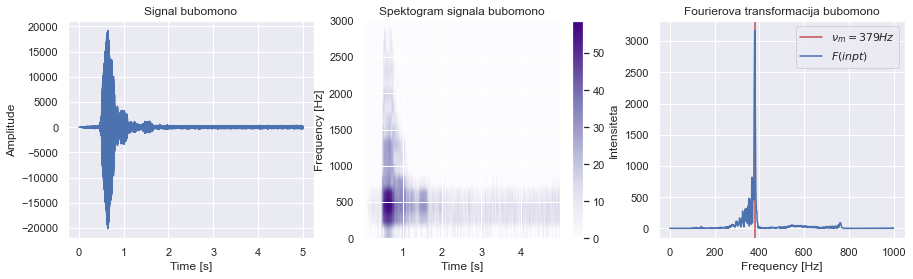

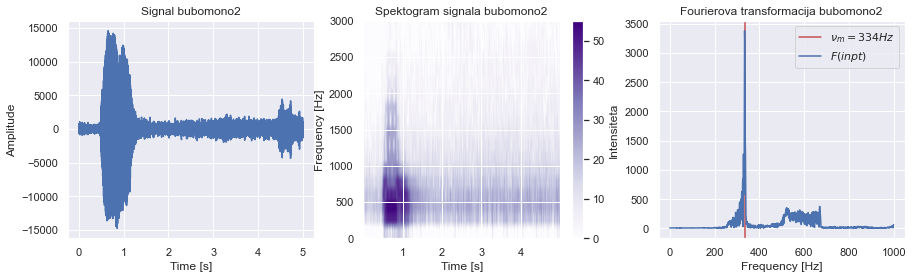

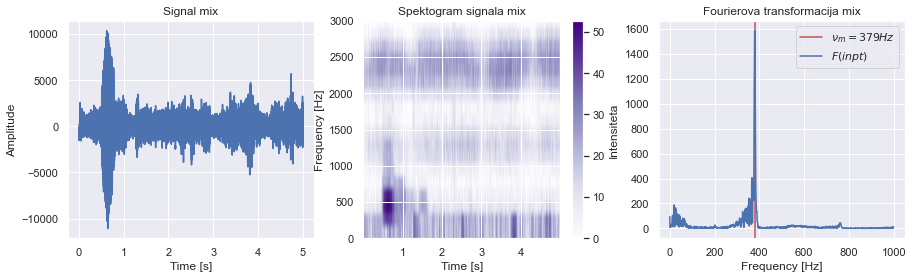

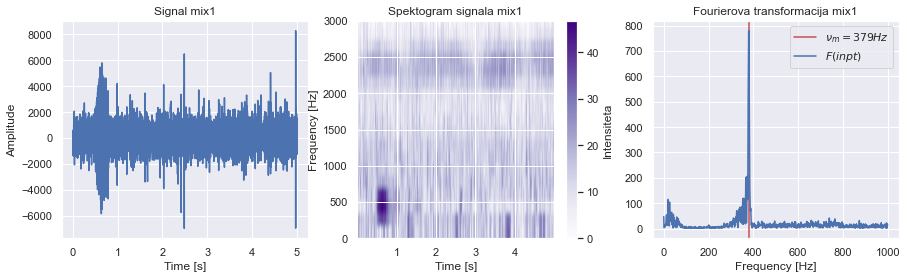

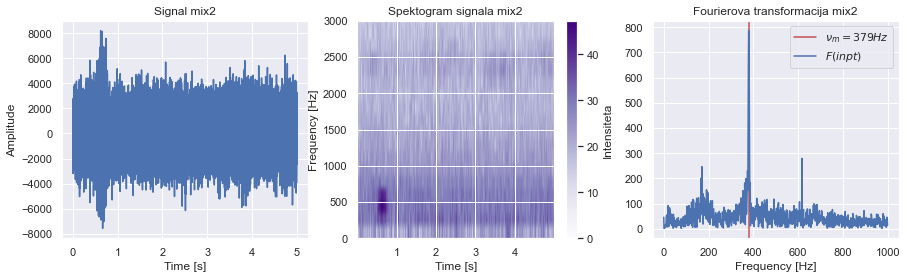

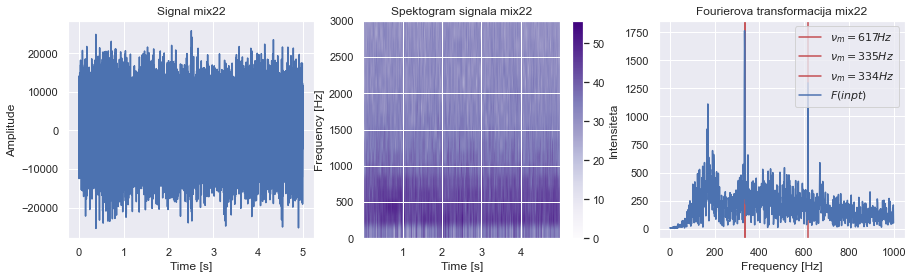

In [20]:
plot_spectogram(bubomono, rate, name='bubomono')
plot_spectogram(bubomono2, rate, name='bubomono2')

plot_spectogram(mix, rate, name='mix')
plot_spectogram(mix1, rate, name='mix1')
plot_spectogram(mix2, rate, name='mix2')
plot_spectogram(mix22, rate, name='mix22', max_freqs=3)

Katera sova je katera je torej očitno iz maksimalne frekvence pri Fourierovi transformaciji. Na spektorgramih se tudi opazi, da je prisotna sova. To se vidi, ker nastane pega pri malo manj kot eni sekundi, raztega pa se na majhnem območju nekje med 250 in 750 Hz. Na grafih so prisotne tudi nekatere frekvence z visoko amplitudo, ki pa so seveda frekvence čričkov. Iz grafov lahko tudi opazimo, da je profesor z miksanjem posnetkov \texttt{mix2} in\texttt{mix22} uporabljal enake posnetke čričkov in vode ter samo povečal intenziteto motenj.

Torej so miksi

\begin{table}[H]
\begin{tabular}{lll}
mix   & bubomono  & 379 Hz \\
mix1  & bubomono  & 379 Hz \\
mix2  & bubomono  & 379 Hz \\
mix22 & bubomono2 & 334 Hz
\end{tabular}
\end{table}


Sedaj lahko nalogo, ki je zelo dobro rešena naredimo tudi na drugačen način.

## Autokorelacija

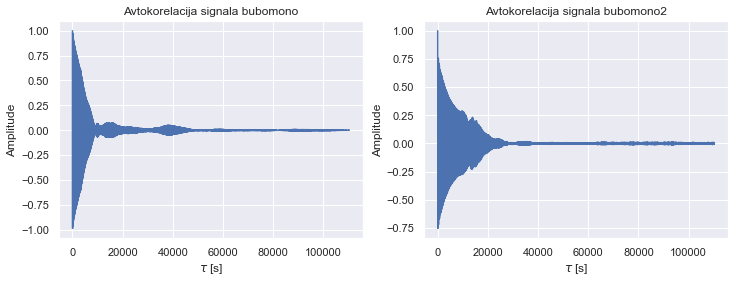

In [21]:
# plt.plot(autocorrelation(bubomono))
# plt.title(f"Avtokorelacija signala bubomono")
# plt.xlabel(r"$\tau$ [s]")
# plt.ylabel("Amplituda")
# plt.savefig(f'plots/bubomono_autocorrelation.pdf', bbox_inches='tight')
# plt.show()

plt.figure(figsize=(12, 4))
plt.tight_layout(pad=0)
plt.subplot(121)
x = np.arange(len(bubomono)/2)
plt.title(f"Avtokorelacija signala bubomono")
plt.xlabel(r"$\tau$ [s]")
plt.ylabel("Amplitude")
plt.plot(x, autocorrelation(bubomono))

plt.subplot(122)
x = np.arange(int(len(bubomono2)/2))
plt.title(f"Avtokorelacija signala bubomono2")
plt.xlabel(r"$\tau$ [s]")
plt.ylabel("Amplitude")
plt.plot(x, autocorrelation(bubomono2))
plt.savefig(f'plots/bubomono_autocorrelation.pdf', bbox_inches='tight')
plt.show()

### korelacija signalov

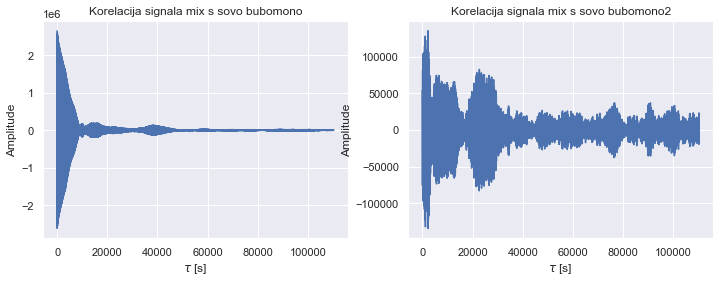

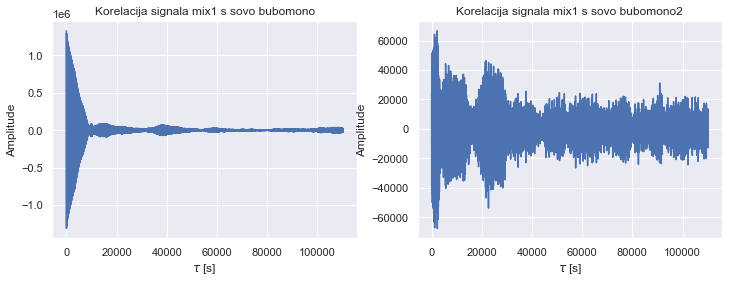

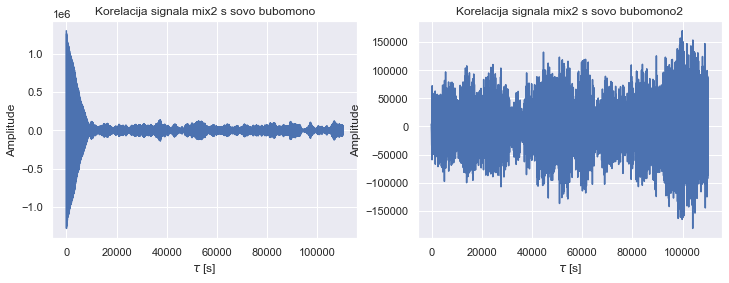

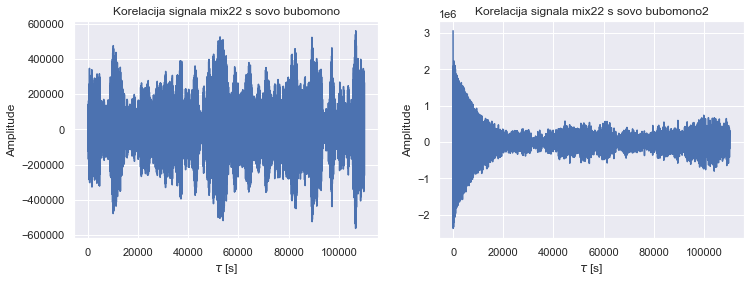

In [22]:
def correlate(g, name):
    plt.figure(figsize=(12, 4))
    plt.tight_layout(pad=0)
    plt.subplot(121)
    x = np.arange(len(bubomono)/2)
    plt.title(f"Korelacija signala {name} s sovo bubomono")
    plt.xlabel(r"$\tau$ [s]")
    plt.ylabel("Amplitude")
    plt.plot(x, phi_gh(bubomono, g))

    plt.subplot(122)
    x = np.arange(int(len(bubomono2)/2))
    plt.title(f"Korelacija signala {name} s sovo bubomono2")
    plt.xlabel(r"$\tau$ [s]")
    plt.ylabel("Amplitude")
    plt.plot(x, phi_gh(bubomono2, g[:-1]))
    plt.savefig(f'plots/{name}_correlation_primerjava.pdf', bbox_inches='tight')
    plt.show()


correlate(mix, 'mix')
correlate(mix1, 'mix1')
correlate(mix2, 'mix2')
correlate(mix22, 'mix22')


Tudi iz slednjih grafov korelacije lahko potrdimo, da tabela katera sova je katera zares drži.

## Dodatna - Shazam

Nared listo 10ih pesmi k jih dobis iz Youtuba in jih spektromektreri, pol pa deli z pesmijo
 s posnetkom k ga predvajas s kompom pa ful background noisa in posnams s fonom -> very fun :)

Shazam je popularna aplikacija za identifikacijo pesmi, ki jih lahko poslušamo s telefonom. Na server strani mora narediti fourierovo transformacijo vseh pesmi, ki jih imajo v databazi in zgenerirati nek fingerprint. Ta algoritem je malo bolj zakompliciran, kot se bom tega lotil jaz, vendar v pricipu se ga da zapakirati tako, da lahko tudi z majhnimi deli oblikujemo fingerprint za celotno pesem. To je zares zelo koristno za identifikacijo, ker moramo z zelo kratkimi odseki pesmi zaznati za katero pesem gre. Avtokorelacija pri njih ne pride v poštev, ker imajo v databazi miljarde pesmi, kar seveda ni smiselno računati za vsako pesem posebej. Torej, kar bom naredil jaz je, da bom za vsako pesem v databazi (imel jih bom 100), zgeneriral fingerprint pesmi z Fourierovo transformacijo na celotni pesmi (vse bodo samplane s 441000 Hz) ter ga s skalarnim produktom primerjal s Fourierovo transformacijo posnetka na telefonu. Tista primerjava, ki bo imela največji skalarni produkt, bo seveda match. Če bi se hotel igrati tudi z outlierji, bi lahko pogledal kje zares je spodnja meja vredonosti skalarnega produkta, da še dobimo nekaj smiselnega. Kar je lahko naslednji korak in kar zelo verjetno tudi počnemo na Shazamu je, da so natrenirali neko nevronsko mrežo, ki je zelo dobra pri odstranjanju "general" šuma iz ozadja ter tudi za idenfikacijo če sploh gre za pesem (kar zelo zmanjša čas procesiranja, ker ne rabimo pošiljat samplov na server, če ne gre za pesem). Vendar to je seveda malo bolj komplicirano. Moj pristop bo zgolj, da bom vzel največjo vrednost skalarnega produkt frekvenc.

#### Nekatere pesmi v datasetu za sample

- https://www.youtube.com/watch?v=S9bCLPwzSC0
- https://www.youtube.com/watch?v=kTJczUoc26U
- https://www.youtube.com/watch?v=UtF6Jej8yb4

In [23]:
directory = 'pesmi/'
for filename in os.listdir(directory):
    os.rename(directory+filename, directory+filename.replace(")", "-"))


In [75]:
# for filename in os.listdir("pesmi"):

#     os.system(f"ffmpeg -i pesmi/{filename} -ac 1 -ar {rate} -acodec pcm_s16le -f wav encoded_pesmi/{filename}.wav")
#     # if filename.endswith(".waw"):
    # print(f"encoded_pesmi/{filename}")


/Users/greg/miniconda3/lib/python3.9/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


.DS_Store


/var/folders/v8/k_3v53n95xj0dq7k0z1tcbv00000gn/T/ipykernel_5939/1488077688.py:22: RuntimeWarning: invalid value encountered in true_divide
  y /= np.max(y)


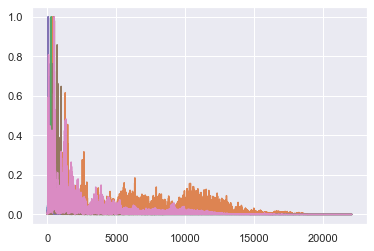

In [76]:
import os
songs = {}
rate = 44100
for filename in os.listdir("encoded_pesmi"):

    # os.system(f"ffmpeg -i pesmi/{filename} -ac 1 -ar {rate} -acodec pcm_s16le -f wav encoded_pesmi/{filename}.wav")
    # if filename.endswith(".waw"):
    # print(f"encoded_pesmi/{filename}")
    try:
        rate, song = read_sound(f"encoded_pesmi/{filename}")
        songs[filename] = song
        # print(rate)
    except:
        print(f"{filename}")

fourieri = {}
freqs = np.arange(rate/2)
for pesem in songs:
    freqs_y = fft.fft(songs[pesem], n=rate)
    # ker itak dobimo simetricno
    y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])
    y /= np.max(y)
    plt.plot(freqs, y, label='$F(inpt)$')
    fourieri[pesem] = y

In [77]:
def special_dot(x,y, alpha=2):
    return np.sum(np.abs(x*y)**alpha)

In [78]:
def compare_db(posnetek, rate=44100):
    freqs_y = fft.fft(posnetek, n=rate)
    # to je zdej fourier nasega posnetka
    y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])

    # vals = {}
    vals = []

    # compare to all
    for four in fourieri:
        val = special_dot(y, fourieri[four])
        vals.append((four,val))

    df = pd.DataFrame(vals, columns=['song', 'value'])
    df = df.sort_values(by='value', ascending=False)
    return df

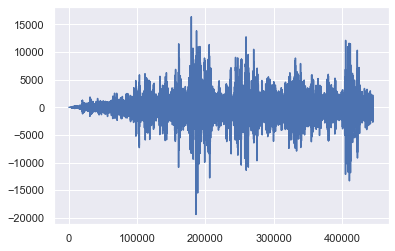

In [79]:
filename = 'save_tears'
# os.system(
#     f"ffmpeg -i recs/{filename}.m4a -ac 1 -ar {rate} -acodec pcm_s16le -f wav recs/{filename}.wav")
_, posnetek = rate, song = read_sound(f"recs/{filename}.wav")
plt.plot(posnetek)

# compare_db(posnetek)

\begin{tabular}{llr}
\toprule
{} &                                               song &         value \\
\midrule
1 &  Avicii-TheNights-UtF6Jej8yb4-192k-163340136690... &  40483.781299 \\
4 &  TheWeeknd-SaveYourTears-OfficialMusicVideo--XX... &  31287.951054 \\
6 &  Eminem-Mockingbird-OfficialMusicVideo--S9bCLPw... &  27159.299280 \\
0 &  TheWeeknd-TakeMyBreath-OfficialMusicVideo--rhT... &  23206.531579 \\
5 &  TheKidLAROI,JustinBieber-STAY-OfficialVideo--k... &  12264.994628 \\
2 &  GlassAnimals-HeatWaves-OfficialVideo--mRD0-Gxq... &   6242.968198 \\
3 &  MikePosner-ITookAPillInIbiza-SeebRemix--Explic... &           NaN \\
\bottomrule
\end{tabular}



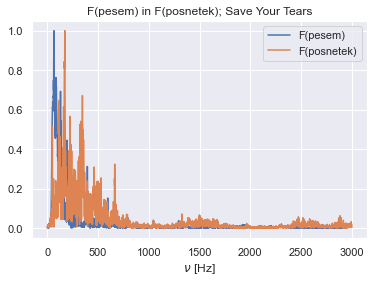

In [80]:
filename = 'save_tears_fucky'
# os.system(
#     f"ffmpeg -i recs/{filename}.m4a -ac 1 -ar {rate} -acodec pcm_s16le -f wav recs/{filename}.wav")
_, posnetek = rate, song = read_sound(f"recs/{filename}.wav")
freqs_y = fft.fft(posnetek, n=rate)
# to je zdej fourier nasega posnetka
y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])
y /= np.max(y)

plt.plot(
    freqs[:3000], fourieri['TheWeeknd-SaveYourTears-OfficialMusicVideo--XXYlFuWEuKI-192k-1633202889221.mp3.wav'][:3000], label='F(pesem)')
plt.plot(freqs[:3000], y[:3000], label='F(posnetek)')
plt.legend()
plt.title(f"F(pesem) in F(posnetek); Save Your Tears")
plt.xlabel(r"$\nu$ [Hz]")
plt.savefig(f'plots/save_tears_fucky.pdf', bbox_inches='tight')
print(compare_db(posnetek).to_latex())

\begin{tabular}{llr}
\toprule
{} &                                               song &        value \\
\midrule
1 &  Avicii-TheNights-UtF6Jej8yb4-192k-163340136690... &  5868.829027 \\
6 &  Eminem-Mockingbird-OfficialMusicVideo--S9bCLPw... &  2562.026471 \\
5 &  TheKidLAROI,JustinBieber-STAY-OfficialVideo--k... &  2240.357660 \\
4 &  TheWeeknd-SaveYourTears-OfficialMusicVideo--XX... &  1578.344091 \\
0 &  TheWeeknd-TakeMyBreath-OfficialMusicVideo--rhT... &   797.569793 \\
2 &  GlassAnimals-HeatWaves-OfficialVideo--mRD0-Gxq... &   581.505771 \\
3 &  MikePosner-ITookAPillInIbiza-SeebRemix--Explic... &          NaN \\
\bottomrule
\end{tabular}



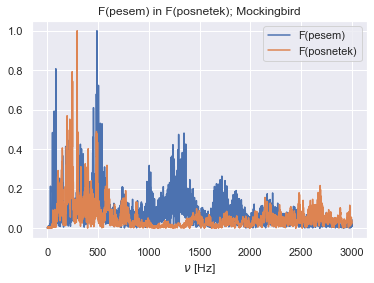

In [89]:
filename = 'mockingbird'
# os.system(
#     f"ffmpeg -i recs/{filename}.m4a -ac 1 -ar {rate} -acodec pcm_s16le -f wav recs/{filename}.wav")
_, posnetek = rate, song = read_sound(f"recs/{filename}.wav")
freqs_y = fft.fft(posnetek, n=rate)
# to je zdej fourier nasega posnetka
y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])
y /= np.max(y)

plt.plot(
    freqs[:3000], fourieri['Eminem-Mockingbird-OfficialMusicVideo--S9bCLPwzSC0-192k-1633195781772.mp3.wav'][:3000], label='F(pesem)')
plt.plot(freqs[:3000], y[:3000], label='F(posnetek)')
plt.legend()
plt.title(f"F(pesem) in F(posnetek); Mockingbird")
plt.xlabel(r"$\nu$ [Hz]")
plt.savefig(f'plots/mockingbird.pdf', bbox_inches='tight')
print(compare_db(posnetek).to_latex())


Zakaj the nights prevlada?

\begin{tabular}{llr}
\toprule
{} &                                               song &        value \\
\midrule
1 &  Avicii-TheNights-UtF6Jej8yb4-192k-163340136690... &  5868.829027 \\
6 &  Eminem-Mockingbird-OfficialMusicVideo--S9bCLPw... &  2562.026471 \\
5 &  TheKidLAROI,JustinBieber-STAY-OfficialVideo--k... &  2240.357660 \\
4 &  TheWeeknd-SaveYourTears-OfficialMusicVideo--XX... &  1578.344091 \\
0 &  TheWeeknd-TakeMyBreath-OfficialMusicVideo--rhT... &   797.569793 \\
2 &  GlassAnimals-HeatWaves-OfficialVideo--mRD0-Gxq... &   581.505771 \\
3 &  MikePosner-ITookAPillInIbiza-SeebRemix--Explic... &          NaN \\
\bottomrule
\end{tabular}



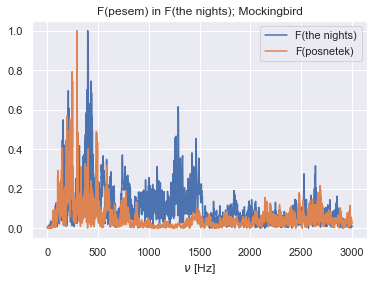

In [88]:
filename = 'mockingbird'
# os.system(
#     f"ffmpeg -i recs/{filename}.m4a -ac 1 -ar {rate} -acodec pcm_s16le -f wav recs/{filename}.wav")
_, posnetek = rate, song = read_sound(f"recs/{filename}.wav")
freqs_y = fft.fft(posnetek, n=rate)
# to je zdej fourier nasega posnetka
y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])
y /= np.max(y)

plt.plot(
    freqs[:3000], fourieri['Avicii-TheNights-UtF6Jej8yb4-192k-1633401366900.mp3.wav'][:3000], label='F(the nights)')
plt.plot(freqs[:3000], y[:3000], label='F(posnetek)')
plt.legend()
plt.title(f"F(pesem) in F(the nights); Mockingbird")
plt.xlabel(r"$\nu$ [Hz]")
plt.savefig(f'plots/mockingbird_z_nights.pdf', bbox_inches='tight')
print(compare_db(posnetek).to_latex())


## KONEC NALOGE
irelevantno

Prišel sem do nezanimivega odkritja, da ta postopek ni vredu. Če naredimo fourierovo transformacijo čez celotno pesem, popolnoma izgubimo podatek o pesmi. Lotiti se moramo drugače. Pesem moramo samplati na vsake 10 sekund (toliko kot traja posnetek) in za vsak čas narediti fourierovo transformacijo. Potem pa za vsak vzorec naredimo korelacijo, ki je pravzaprav v tem trenutku zgolj še inverzna Fourierova transformacija.

NEZANIMIVO, ker je isto

In [64]:
# fouriers = {}
# rate = 44100

# for filename in os.listdir("encoded_pesmi"):

#     # os.system(f"ffmpeg -i pesmi/{filename} -ac 1 -ar {rate} -acodec pcm_s16le -f wav encoded_pesmi/{filename}.wav")
#     # if filename.endswith(".waw"):
#     # print(f"encoded_pesmi/{filename}")
#     rate, song = read_sound(f"encoded_pesmi/{filename}")
#     length = len(song)/rate

#     fouriers[filename] = []

#     for i in range(int(length/10)): # for all 10 second periods
#         sample = song[i*rate*10:(i+1)*rate*10]
#         freqs_y = fft.fft(sample, n=rate)
#         # to je zdej fourier nasega posnetka
#         y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])
#         y /= np.max(y)
#         fouriers[filename].append(y)

#     # songs[filename] = song
#     # print(rate)


In [63]:
# def compare_db(posnetek, rate=44100):
#     freqs_y = fft.fft(posnetek[:441000], n=rate)
#     # to je zdej fourier nasega posnetka
#     y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])
#     y /= np.max(y)

#     # vals = {}
#     vals = []

#     # compare to all
#     for four in fourieri:
#         vals_curr = []
#         for sec in fourieri[four]:
#             P = sec*np.conj(y)
#             # p = np.absolute(f)**2
#             Pi = fft.ifft(P)
#             val = np.max(Pi)
#             vals_curr.append(val)
#         val = np.mean(vals_curr)
#         vals.append((four, val))

#     df = pd.DataFrame(vals, columns=['song', 'value'])
#     df = df.sort_values(by='value', ascending=False)
#     return df


In [62]:
# filename = 'mockingbird'
# # os.system(
# #     f"ffmpeg -i recs/{filename}.m4a -ac 1 -ar {rate} -acodec pcm_s16le -f wav recs/{filename}.wav")
# _, posnetek = rate, song = read_sound(f"recs/{filename}.wav")
# # freqs_y = fft.fft(posnetek, n=rate)
# # # to je zdej fourier nasega posnetka
# # y = 2/len(freqs_y) * np.abs(freqs_y[0:int(len(freqs_y)/2)])

# # plt.plot(
# #     freqs, fouriers['Eminem-Mockingbird-OfficialMusicVideo--S9bCLPwzSC0-192k-1633195781772.mp3.wav'][5])
# # plt.plot(freqs, y)

# compare_db(posnetek)